In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-28 09:44:21.881454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 09:44:21.881507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 09:44:21.882939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')

# load joint embeddings
#with open('/kaggle/input/j-embeds-bal/j_embeds_train (1).pkl', 'rb') as f:
    #v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/j-embeds-bal/j_embeds_val (1).pkl', 'rb') as f:
    j_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/j-embeds-bal/j_embeds_test (2).pkl', 'rb') as f:
    j_embeds_test = pickle.load(f) 

In [3]:
print(len(j_embeds_test)) # Liste aus Tensors
print(j_embeds_test[0].shape)
print(type(j_embeds_test[0]))
print(j_embeds_test[0].device)

89
torch.Size([612, 768])
<class 'torch.Tensor'>
cuda:0


In [4]:
#load training embeddings one by one, foldername: j-embeds_bal_train-batches, and concatenate them
folder_path = "/kaggle/input/batch-train-j-features"
embedding_tensors = []

batches = 15
for i in range(batches): # number of batches of training joint embeddings
    file_path = os.path.join(folder_path, f'batch_{i+1}_v_features_test.pkl')  # Adjust the file naming convention as needed (made an error, should be called j_features since they are joint features)
    with open(file_path, 'rb') as f:
        j_embeds_batch = pickle.load(f) 
    embed_batch = torch.stack(j_embeds_batch, dim=0) # make a tensor out of the list of tensors
    embedding_tensors.append(embed_batch) # append tensor to the list of all training batch tensors


concatenated_tensor = torch.cat(embedding_tensors, dim=0) # concatenate tensors of tensor list
concatenated_tensor = concatenated_tensor.cpu().numpy() # push from cuda to cpu and convert to numpy array
print(concatenated_tensor.shape) # should be (len(training_df),612,768) # 300 worked!

(1500, 612, 768)


In [5]:
#X_train = torch.stack(j_embeds_test[:70], dim=0).cpu().numpy()
X_train = concatenated_tensor
#X_val = torch.stack(j_embeds_test[70:80], dim=0).cpu().numpy()
X_val = torch.stack(j_embeds_val, dim=0).cpu().numpy()
#X_test = torch.stack(j_embeds_test[80:89], dim=0).cpu().numpy()
X_test = torch.stack(j_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1500, 612, 768) (89, 612, 768) (89, 612, 768)


In [6]:
# convert labels to numerical values
label_encoder = LabelEncoder()
#labels = df_test['AUTHOR'].tolist()
#y_train = labels[:70]
#y_val = labels[70:80]
#y_test = labels[80:89]

split = batches*100

y_train = df_train['AUTHOR'].tolist()[:split]
#y_train = df_train['AUTHOR'].tolist()
y_val = df_val['AUTHOR'].tolist()
y_test = df_test['AUTHOR'].tolist()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print(y_test)

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

[5 5 5 7 0 3 4 3 9 2 0 4 8 8 8 7 2 5 4 0 4 8 2 6 4 7 9 7 2 9 6 2 3 2 5 6 5
 1 0 8 8 7 3 9 4 1 1 0 1 4 5 4 8 3 0 5 8 0 8 5 1 9 5 3 1 1 5 2 7 3 8 6 4 0
 7 5 8 4 6 3 9 5 1 3 8 4 6 9 9]
['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [7]:
# save results for one random seed, restart sessions and then concatenate DataFrames (otherwise ResourceExhaustedError)
def create_model():
    
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(612, 768)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
    
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optim,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

results = [] # store results obtained by training model with 10 different random seeds
all_val_accuracies = [] # nested list of all validation accuracies for all random seeds

seed = 9 # seeds from 0 to 9

np.random.seed(seed) # set random seed
tf.random.set_seed(seed)

model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # perform early stopping
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
all_val_accuracies.append(history.history['val_accuracy']) # store accuracies for all epochs of one random seed
    
# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# get validation and test accuracy for every random seed
results.append({'seed': seed, 'val_accuracy': val_accuracy, 'test_accuracy': test_accuracy})


# save results to CSV

results_df = pd.DataFrame(results)
results_df.to_csv(f'joint_results_seed{seed}.csv', index=True)
print(results_df.head())

all_val_accuracies_df = pd.DataFrame(all_val_accuracies, 
                                     columns=[f'epoch {i+1}' for i in range(len(all_val_accuracies[0]))])

all_val_accuracies_df.insert(0, 'seed', [f'{seed}'])
all_val_accuracies_df.to_csv(f'joint_results_seed{seed}_all_val_accuracies.csv', index=True)
all_val_accuracies_df.head()

I0000 00:00:1716889496.511763    6430 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716889496.525970    6430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716889502.920270    6428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6999 - loss: 1.0331 
Validation Loss: 1.0562204122543335, Validation Accuracy: 0.6966292262077332
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6601 - loss: 1.0844 
Test Loss: 1.1213966608047485, Test Accuracy: 0.6404494643211365
   seed  val_accuracy  test_accuracy
0     9      0.696629       0.640449


,seed,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10,epoch 11,epoch 12,epoch 13,epoch 14
0,9,0.157303,0.314607,0.370787,0.426966,0.516854,0.52809,0.58427,0.640449,0.651685,0.662921,0.696629,0.685393,0.651685,0.640449


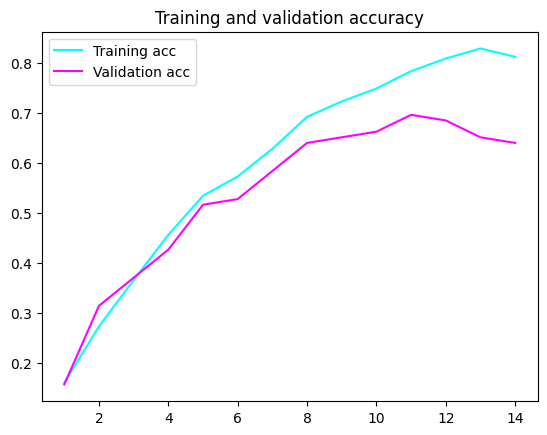

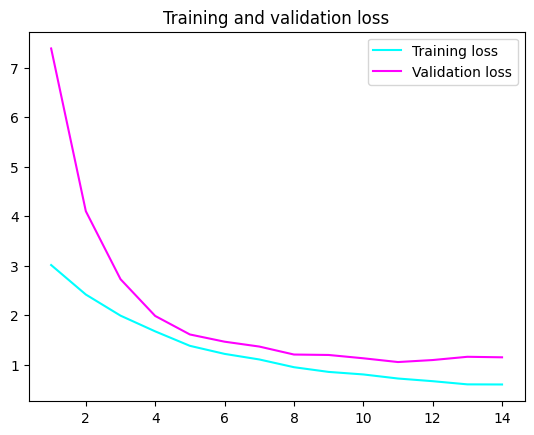

In [8]:
# plot training and validation accuracy and loss (for random seed = 9)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step

W0000 00:00:1716889533.437626    6429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


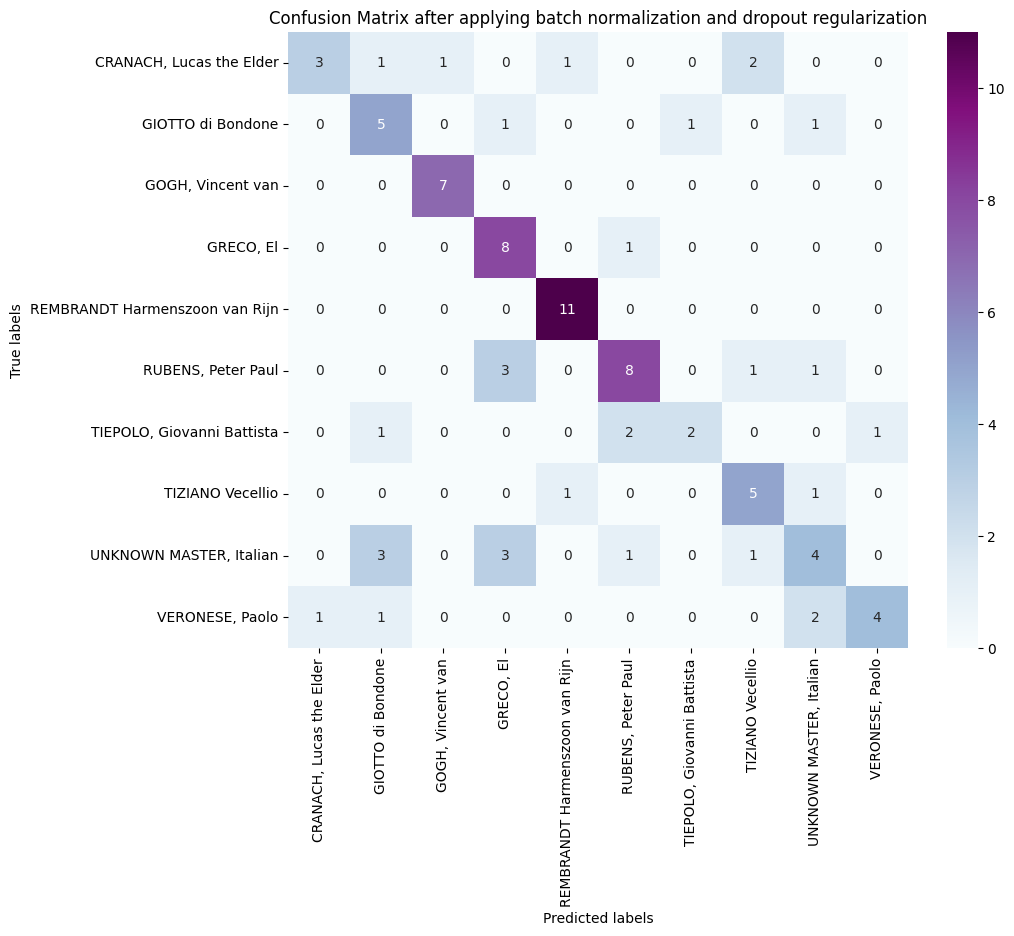

In [9]:
# confusion matrix after applying batch normalization and dropout regularization (for random seed = 9)

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after applying batch normalization and dropout regularization')
plt.show()

In [10]:
# concatenate files for all random seeds
directory = "/kaggle/working"

files = os.listdir(directory)
print(len(files))

# filter out irrelevant files
csv_files = [file for file in files if file.endswith('.csv') and not(file.endswith('joint_all_val_accuracies.csv') or file.endswith('joint_results.csv')) ]
print(len(csv_files))

# separate files into all_val_accuracies and results
all_val_accuracies_files = [file for file in csv_files if "all_val_accuracies" in file]
results_files = [file for file in csv_files if "all_val_accuracies" not in file]

# concatenate files horizontally
all_val_accuracies_dfs = []

for file in all_val_accuracies_files:
    df = pd.read_csv(os.path.join(directory, file))
    all_val_accuracies_dfs.append(df)


results_dfs = []
for file in results_files:
    df = pd.read_csv(os.path.join(directory, file))
    results_dfs.append(df)

# concatenate DataFrames horizontally
concatenated_all_val_accuracies = pd.concat(all_val_accuracies_dfs, axis=0)
concatenated_results = pd.concat(results_dfs, axis=0) 

# drop first columns
concatenated_all_val_accuracies = concatenated_all_val_accuracies.drop(concatenated_all_val_accuracies.columns[0], axis=1)
concatenated_results = concatenated_results.drop(concatenated_results.columns[0], axis=1)

# order rows regarding seed 
concatenated_all_val_accuracies = concatenated_all_val_accuracies.sort_values(by='seed')
concatenated_results = concatenated_results.sort_values(by='seed')

# save concatenated DataFrames to new CSV files
concatenated_all_val_accuracies.to_csv("/kaggle/working/joint_all_val_accuracies.csv", index=False)
concatenated_results.to_csv("/kaggle/working/joint_results.csv", index=False)
concatenated_results

23
20


,seed,val_accuracy,test_accuracy
0,0,0.685393,0.662921
0,1,0.707865,0.606742
0,2,0.651685,0.640449
0,3,0.662921,0.640449
0,4,0.707865,0.651685
0,5,0.696629,0.651685
0,6,0.719101,0.674157
0,7,0.662921,0.685393
0,8,0.662921,0.573034
0,9,0.696629,0.640449
